In [1]:
#importing required libraries
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from wordcloud import WordCloud
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time as tt
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder


#Exploitory data analysis.

In [2]:
#loading the data
df = pd.read_csv("banking.csv")

#Exploitory data analysis.
print(f'length of data : {len(df["text"])}')
print(f'length of target: {len(df["label"])}')

# print the first data point from the training data, which is the first element in the list
print(df['text'][0])
# Check what type of variable this first data point is
print(type(df['text'][0]))

# print(df)
# OK, so the text data point is a string. 
# We see the query_index data point has hashed value which is probably not contribute to the model.
# here converted to a new list which will only hold the required feature('text') and label.
bank_dataset = pd.DataFrame(df,columns=['text','label'])
bank_dataset.head(3)

length of data : 14195
length of target: 14195
Can I automatically top-up when traveling?
<class 'str'>


,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other


In [3]:
# checking what the labels are and what is their distribution
# using value_counts to get the number of occurrences for each unique value in the dataframe column
bank_dataset['label'].value_counts()
# here we can see the labels have apeared in repeation beacuse of the case of the text. But the label meaning is same.
# the case of the all labels must be change in to same case to avoid this.

other                       5036
needs_troubleshooting       4305
card_queries_or_issues      2598
top_up_queries_or_issues    1684
Other                         21
Card_queries_or_issues        12
Top_up_queries_or_issues      11
Needs_troubleshooting          7
Name: label, dtype: int64

In [4]:

# Convert label column to Capitalized
bank_dataset.loc[bank_dataset.label=='other','label'] = 'Other'
bank_dataset.loc[bank_dataset.label=='needs_troubleshooting','label'] = 'Needs_troubleshooting'
bank_dataset.loc[bank_dataset.label=='card_queries_or_issues','label'] = 'Card_queries_or_issues'
bank_dataset.loc[bank_dataset.label=='top_up_queries_or_issues','label'] = 'Top_up_queries_or_issues'
bank_dataset['label'].value_counts()

Other                       5057
Needs_troubleshooting       4312
Card_queries_or_issues      2610
Top_up_queries_or_issues    1695
Name: label, dtype: int64

<Axes: >

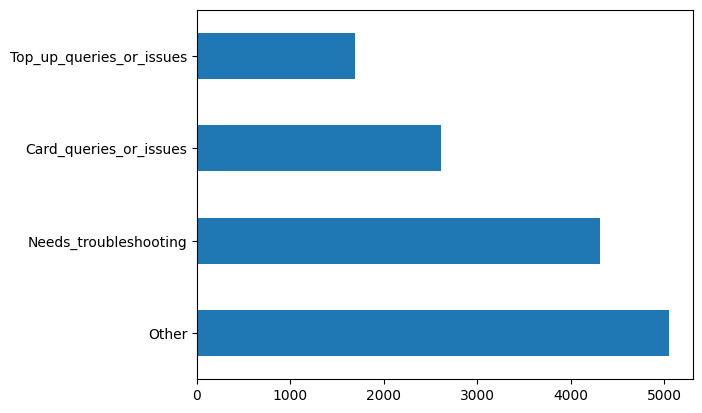

In [5]:
# It seems the data is imbalanced, Since the value difference of each category is higher.
bank_dataset['label'].value_counts().plot(kind='barh')

In [6]:
# check for the missing values
print(bank_dataset.isna().sum())
bank_dataset = bank_dataset.dropna()

text       0
label    521
dtype: int64


In [7]:
# check for the duplicates
print(bank_dataset.duplicated().sum())
bank_dataset = bank_dataset.drop_duplicates()
# after removing the duplicated null rows and duplicate rows
bank_dataset['label'].value_counts()
# still the classes are imbalanced. will sort this in later steps.

587


Other                       4804
Needs_troubleshooting       4154
Card_queries_or_issues      2496
Top_up_queries_or_issues    1633
Name: label, dtype: int64

In [8]:
#going through the entire text cleaning pipeline:
# 1. Text cleaning
# 2. Tokenization
# 3. Lemmatization
# 4. Remove stop words, punctuation, etc.
# 5. Scaling up to collections of documents
# using a very useful NLP package 'Spacy'.

# creating a spacy pipeline to process text data.
nlp = spacy.load('en_core_web_sm')

# 2. tokenization
# creating a spacy doc
doc = nlp(bank_dataset.iloc[1]['text'])

print("original text : ",bank_dataset.iloc[1]['text'])

# the "doc" contains all the tokens that the text was split into
# Can be seen them all by iterating through the document
for i,token in enumerate(doc):
  print(f'token number : {i}, text : "{token.text}"')
  if(i > 20):
    break

original text :  What kind of fiat currency can I used for holding and exchange?
token number : 0, text : "What"
token number : 1, text : "kind"
token number : 2, text : "of"
token number : 3, text : "fiat"
token number : 4, text : "currency"
token number : 5, text : "can"
token number : 6, text : "I"
token number : 7, text : "used"
token number : 8, text : "for"
token number : 9, text : "holding"
token number : 10, text : "and"
token number : 11, text : "exchange"
token number : 12, text : "?"


In [9]:
# 3. lemmatization
# checking the lemmatized tokens
for i,token in enumerate(doc):
  print(f'token number : {i}, text : "{token.text}", lemmatised : "{token.lemma_}"')
  if(i > 20):
    break
# most words have been made lowercase. This makes sense as "What" conveys the same meaning as "what". 
# However, there are some exceptions like 'I' and also some words transformed to a generic version like 'holding' to 'hold.

token number : 0, text : "What", lemmatised : "what"
token number : 1, text : "kind", lemmatised : "kind"
token number : 2, text : "of", lemmatised : "of"
token number : 3, text : "fiat", lemmatised : "fiat"
token number : 4, text : "currency", lemmatised : "currency"
token number : 5, text : "can", lemmatised : "can"
token number : 6, text : "I", lemmatised : "I"
token number : 7, text : "used", lemmatised : "use"
token number : 8, text : "for", lemmatised : "for"
token number : 9, text : "holding", lemmatised : "hold"
token number : 10, text : "and", lemmatised : "and"
token number : 11, text : "exchange", lemmatised : "exchange"
token number : 12, text : "?", lemmatised : "?"


In [10]:
# 4. Removing stop words, punctuation, etc.
# checking which tokens are stop words in spacy using is_stop attribute.
for i,token in enumerate(doc):
  print(f'token number : {i}, text : "{token.text}", lemmatised : "{token.lemma_}", is_stop : '+ ("Yes" if token.is_stop else "No"))
  if(i > 20):
    break

token number : 0, text : "What", lemmatised : "what", is_stop : Yes
token number : 1, text : "kind", lemmatised : "kind", is_stop : No
token number : 2, text : "of", lemmatised : "of", is_stop : Yes
token number : 3, text : "fiat", lemmatised : "fiat", is_stop : No
token number : 4, text : "currency", lemmatised : "currency", is_stop : No
token number : 5, text : "can", lemmatised : "can", is_stop : Yes
token number : 6, text : "I", lemmatised : "I", is_stop : Yes
token number : 7, text : "used", lemmatised : "use", is_stop : Yes
token number : 8, text : "for", lemmatised : "for", is_stop : Yes
token number : 9, text : "holding", lemmatised : "hold", is_stop : No
token number : 10, text : "and", lemmatised : "and", is_stop : Yes
token number : 11, text : "exchange", lemmatised : "exchange", is_stop : No
token number : 12, text : "?", lemmatised : "?", is_stop : No


In [11]:
# checking whether a given token is a punctuation symbol or not.(!,?,.)
for i,token in enumerate(doc):
  print(f'token number : {i}, text : "{token.text}", lemmatised : "{token.lemma_}", is_puctuation : '+ ("Yes" if token.is_punct else "No"))
  if(i > 20):
    break

token number : 0, text : "What", lemmatised : "what", is_puctuation : No
token number : 1, text : "kind", lemmatised : "kind", is_puctuation : No
token number : 2, text : "of", lemmatised : "of", is_puctuation : No
token number : 3, text : "fiat", lemmatised : "fiat", is_puctuation : No
token number : 4, text : "currency", lemmatised : "currency", is_puctuation : No
token number : 5, text : "can", lemmatised : "can", is_puctuation : No
token number : 6, text : "I", lemmatised : "I", is_puctuation : No
token number : 7, text : "used", lemmatised : "use", is_puctuation : No
token number : 8, text : "for", lemmatised : "for", is_puctuation : No
token number : 9, text : "holding", lemmatised : "hold", is_puctuation : No
token number : 10, text : "and", lemmatised : "and", is_puctuation : No
token number : 11, text : "exchange", lemmatised : "exchange", is_puctuation : No
token number : 12, text : "?", lemmatised : "?", is_puctuation : Yes


In [12]:
# filtering non stopwords and non punctuation
processed_tokens_list = []
for i,token in enumerate(doc):
  if not token.is_stop and not token.is_punct:
    processed_tokens_list.append(token.lemma_)

processed_doc = ' '.join(processed_tokens_list)
print('doc original :'+ doc.text)
print('processed : '+ processed_doc)

doc original :What kind of fiat currency can I used for holding and exchange?
processed : kind fiat currency hold exchange


In [13]:
# processing corpus with spacy. corpus is a collection of documents. 
# using nlp.pipe() to transform all doc in the training data.
# removing stop and punctuations of the entire documents.

bank_dataset_processed = []
for doc in nlp.pipe(bank_dataset['text']):
    tokens = [token.text for token in doc if not token.is_stop and token.pos_ != "PUNCT"]
    bank_dataset_processed.append(" ".join(tokens))

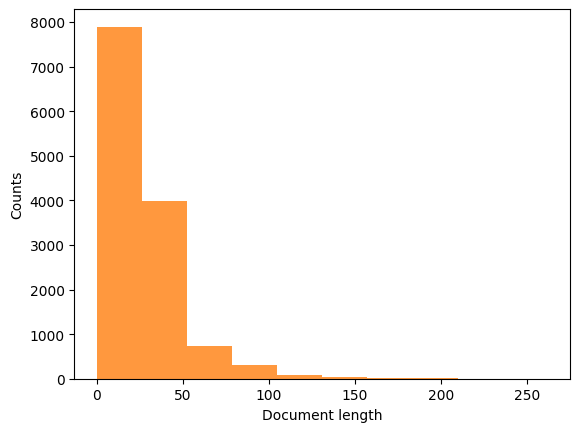

In [14]:
# get the lenght of all processed tokens in the dataset
bank_doc_lengths= []
for doc in bank_dataset_processed:
  bank_doc_lengths.append(len(doc)) #doc.text contains the whole text of the original document

# plot the distribution of lengths in an histogram
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(bank_doc_lengths,color='C1',alpha=0.8)
ax.set_xlabel('Document length')
_ =ax.set_ylabel('Counts')

In [15]:
# displaying word cloud
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


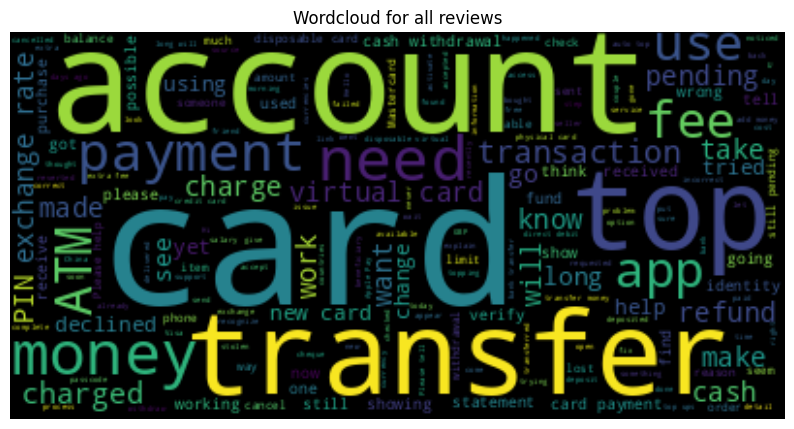

In [16]:
wordcloud = WordCloud().generate(' '.join(bank_dataset['text'].tolist()))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
_ = plt.title('Wordcloud for all reviews')

In [17]:
# dividing the data into training and test.
X_train, X_test, y_train, y_test = train_test_split(bank_dataset['text'], bank_dataset['label'], test_size=0.2, random_state=42)

# Multiclass Classification

In [18]:
# developing pipeline for the classification
# implementing the DencseTransformer class to convert sparseMatrix to dense array.
# create custom class to add to the pipeline


class DenseTransformer(TransformerMixin):
    ''' Pipeline step to transform a sparse matrix into a dense one '''
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()


# here ingoring the the tokenized data processed using Spacy and applying TfidfVectorizer.
# Since found that the data is imbalanced, here using the ImbPipeline().
bal_clf_ = ImbPipeline(
        steps = [('tfidf', TfidfVectorizer(stop_words='english', lowercase= True,
                                           ngram_range=(1,2))),
          ('to_dense', DenseTransformer()),
          ('resampling', RandomOverSampler(random_state=0)),
          ('classifier', SGDClassifier(random_state=0)) #clf_name(random_state=0)
        ]
    )


In [19]:
bal_parameters = {'tfidf__max_features': (2000,10000),
              'classifier__eta0': np.logspace(-5,-1,3), 
              'classifier__learning_rate': ['constant', 'adaptive'],
             }

In [20]:

# using cross-validated GridSearch to get the best hyperparameters.
# balanced data
bal_clf_search = GridSearchCV(bal_clf_, bal_parameters, scoring= "balanced_accuracy", cv= 5)

t0= tt()
_ =bal_clf_search.fit(X_train, y_train)
print(f'Time taken to train gridsearch: {tt()-t0:.2f} seconds.')

Time taken to train gridsearch: 2998.69 seconds.


In [21]:
# combination of hyper-parameters gave the best results when tested using cross-validation
print(bal_clf_search.best_score_, bal_clf_search.best_params_)

0.8725111047994389 {'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'tfidf__max_features': 10000}


In [22]:
# let's show the dataframe
bal_clf_cv_results = pd.DataFrame(bal_clf_search.cv_results_)
print(bal_clf_cv_results.head())

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       9.008333      0.882932         0.065714        0.009877   
1      38.776755      2.930258         0.209872        0.039461   
2      10.635307      0.181440         0.070830        0.018870   
3      50.023992      1.228817         0.269233        0.119957   
4      27.188986      4.282315         0.082822        0.031289   

  param_classifier__eta0 param_classifier__learning_rate  \
0                0.00001                        constant   
1                0.00001                        constant   
2                0.00001                        adaptive   
3                0.00001                        adaptive   
4                  0.001                        constant   

  param_tfidf__max_features  \
0                      2000   
1                     10000   
2                      2000   
3                     10000   
4                      2000   

                                              par

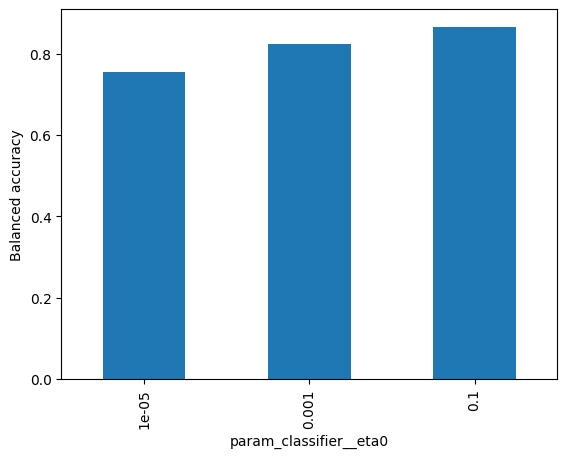

In [23]:
# plot the average crossed validated score for one individual hyper-parameter
# groupby groups together all the rows with the same value of the hyper-parameter of interest
df_group= bal_clf_cv_results.groupby('param_classifier__eta0')
# average the cross validated score for each different value of the hyper-parameter
avg_score = df_group.mean_test_score.agg('mean')
# plotting the results
ax =avg_score.plot(kind='bar')
_ =plt.ylabel('Balanced accuracy')
fig = ax.get_figure()

**Evaluation**


In [24]:
# Get the best estimator for further analysis of the results using the test set
best_bal_clf = bal_clf_search.best_estimator_

                          precision    recall  f1-score   support

  Card_queries_or_issues       0.82      0.93      0.87       463
   Needs_troubleshooting       0.86      0.88      0.87       818
                   Other       0.91      0.85      0.88       998
Top_up_queries_or_issues       0.89      0.85      0.87       339

                accuracy                           0.87      2618
               macro avg       0.87      0.88      0.87      2618
            weighted avg       0.88      0.87      0.87      2618

0.877490435005964


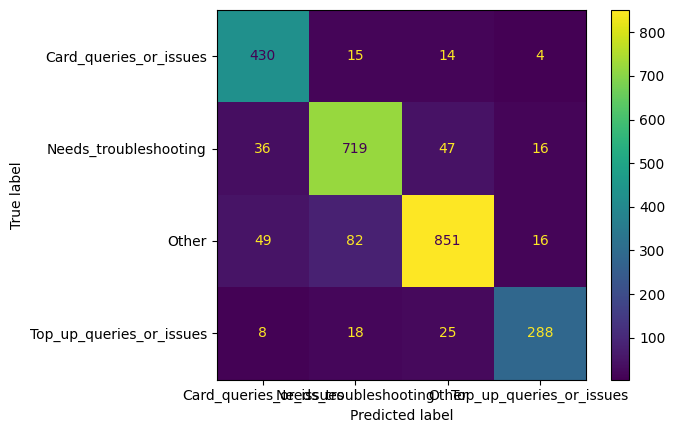

In [25]:

# balanced data
bal_y_pred = best_bal_clf.predict(X_test)
print(classification_report(y_test, bal_y_pred))
# balanced accuracy score:
print(balanced_accuracy_score(y_test, bal_y_pred))
bal_cm = ConfusionMatrixDisplay.from_estimator(best_bal_clf, X_test, y_test)


# **Artificial Neaural Networks**

In [26]:

le = LabelEncoder()
le.fit(y_train)
y_train = pd.DataFrame(le.transform(y_train))
y_test = pd.DataFrame(le.transform(y_test))


# Create the pipeline with data balancing
bal_preprocessor = ImbPipeline(
        steps = [('tfidf', TfidfVectorizer(stop_words='english', lowercase= True,
                                           max_features = 10000,
                                           ngram_range=(1,2))),
          ('to_dense', DenseTransformer()),
        ]
    )


# Preprocess the data
# fit
bal_preprocessor.fit(X_train)
# transform training data
X_train_preprocessed = bal_preprocessor.transform(X_train)
# transform test data
X_test_preprocessed = bal_preprocessor.transform(X_test)

# creates model
model = models.Sequential()
# created a hidden layer with 50 nodes. 
hidden_layer_nodes = 50
num_of_input_features = X_train_preprocessed.shape[1] 

# creating hidden layers
model.add(layers.Input(shape=(num_of_input_features,))) 
model.add(layers.Dense(hidden_layer_nodes, activation='relu'))
model.add(layers.Dense(hidden_layer_nodes, activation='relu'))
# adding a dropout layer
dropout_rate = 0.2
model.add(layers.Dropout(rate= dropout_rate))
num_categories = len(y_train.value_counts())
model.add(layers.Dense(num_categories, activation='softmax')) 

learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

# print a summary of the model to see what it's like
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                500050    
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 204       
                                                                 
Total params: 502,804
Trainable params: 502,804
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
# Training
# defining some relevant hyper-parameters:
batch_size = 100 
epochs = 70 #how long train the model for
validation_split = 0.2  #Fraction of the training data to be used as validation data.
history = model.fit(X_train_preprocessed, 
                    y_train.to_numpy(),
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split= validation_split,
                    )

history.history.keys()

Epoch 1/70
84/84 [==============================] - 2s 20ms/step - loss: 1.3163 - accuracy: 0.3635 - val_loss: 1.2973 - val_accuracy: 0.3873
Epoch 2/70
84/84 [==============================] - 1s 14ms/step - loss: 1.2859 - accuracy: 0.3864 - val_loss: 1.2680 - val_accuracy: 0.3653
Epoch 3/70
84/84 [==============================] - 1s 14ms/step - loss: 1.2407 - accuracy: 0.4364 - val_loss: 1.2034 - val_accuracy: 0.3930
Epoch 4/70
84/84 [==============================] - 1s 13ms/step - loss: 1.1511 - accuracy: 0.5457 - val_loss: 1.0940 - val_accuracy: 0.6113
Epoch 5/70
84/84 [==============================] - 1s 14ms/step - loss: 1.0203 - accuracy: 0.6547 - val_loss: 0.9446 - val_accuracy: 0.6824
Epoch 6/70
84/84 [==============================] - 2s 21ms/step - loss: 0.8820 - accuracy: 0.6947 - val_loss: 0.8230 - val_accuracy: 0.7297
Epoch 7/70
84/84 [==============================] - 2s 21ms/step - loss: 0.7818 - accuracy: 0.7139 - val_loss: 0.7721 - val_accuracy: 0.7039
Epoch 8/70
84

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

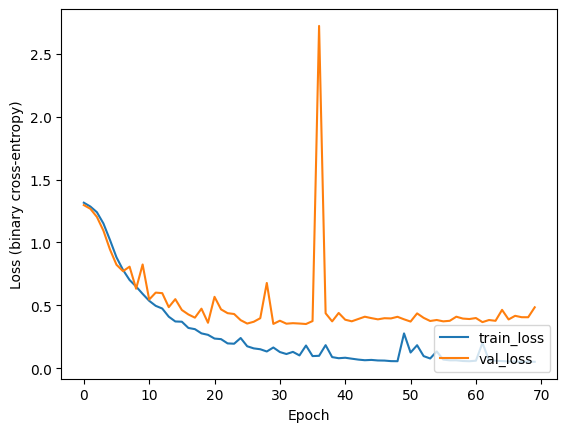

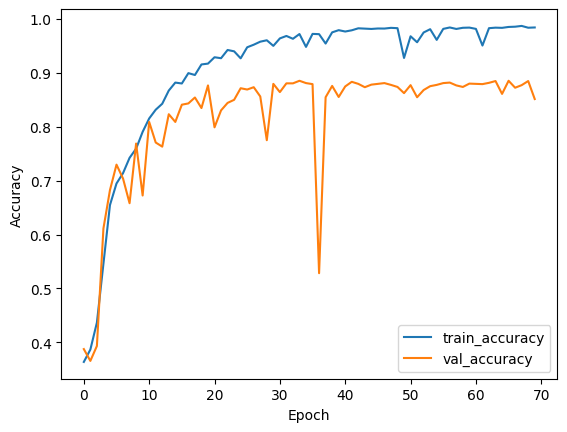

In [28]:
# Plot training curves for both training and validation data
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (binary cross-entropy)')
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

82/82 [==============================] - 0s 3ms/step
(2618, 4)
(2618,)
                          precision    recall  f1-score   support

                   Other       0.88      0.87      0.88       463
   Needs_troubleshooting       0.83      0.91      0.87       818
  Card_queries_or_issues       0.94      0.79      0.86       998
Top_up_queries_or_issues       0.72      0.91      0.81       339

                accuracy                           0.86      2618
               macro avg       0.84      0.87      0.85      2618
            weighted avg       0.87      0.86      0.86      2618

The balanced accuracy score is 0.8699



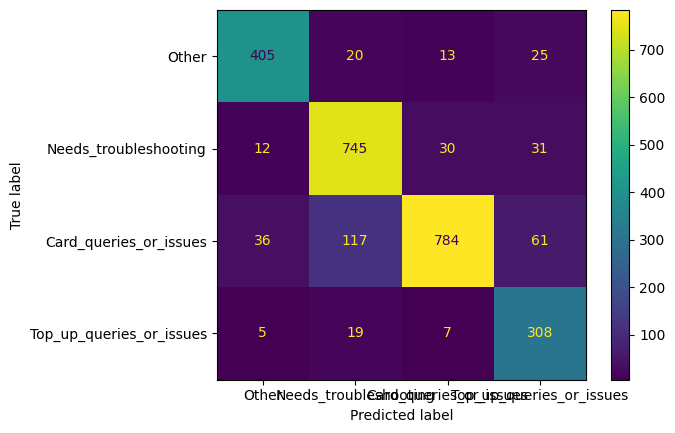

In [29]:


# Check performance on test data
test_probabilities = model.predict(X_test_preprocessed)
# Since it's a multiclass problem, the output probabilities are given as one probability PER CLASS
print(test_probabilities.shape)
# To get the final predicted label, need to find the category with the HIGHEST probability
# this can be taken by the function np.argmax()
test_predictions = np.argmax(test_probabilities, axis=1)
# the result should be one integer number per data point that we can compare with the target labels
print(test_predictions.shape)

target_names = ["Other", "Needs_troubleshooting", "Card_queries_or_issues", "Top_up_queries_or_issues"] 

# showing the classification report with all the metrics
print(classification_report(y_test.to_numpy(),test_predictions, 
                            target_names= target_names)) # this is to give the real categories, not their encoded numbers


# printing the balanced accuracy score, since the dataset is not balanced
print(f'The balanced accuracy score is {balanced_accuracy_score(y_test.to_numpy(),test_predictions):.4f}\n')

# get all the numbers for the confusion matrix
cm = confusion_matrix(y_test.to_numpy(),test_predictions)

# showing the confusion matrix in a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels= target_names) 
disp.plot()
plt.show()